# Identifying Small Mean Reverting Portfolios in Crypto

In [207]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns
import scipy
from IPython.display import display, HTML
import cvxpy as cp
from scipy.linalg import sqrtm
from sklearn.linear_model import Lasso
from sklearn.covariance import GraphicalLasso, LedoitWolf, MinCovDet
from sklearn.preprocessing import StandardScaler

In [208]:
df = pd.read_csv("data/closing_prices.csv", index_col=0).iloc[:-1, :]
print(df.shape)
df.head()

(29417, 44)


,LTCUSDT,EGLDUSDT,ZECUSDT,DOTUSDT,SHIBUSDT,FLOWUSDT,ADAUSDT,LINKUSDT,VETUSDT,ATOMUSDT,...,MANAUSDT,1INCHUSDT,BCHUSDT,HBARUSDT,ALGOUSDT,KSMUSDT,GRTUSDT,CHZUSDT,STXUSDT,XLMUSDT
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-07-30 13:00:00,136.36,83.46,102.92,14.504,0.000006,23.67,1.2586,18.982,0.08054,11.474,...,0.6846,2.1922,525.57,0.20662,0.8165,184.15,0.5654,0.25321,1.2061,0.26501
2021-07-30 14:00:00,137.18,84.15,104.19,14.654,0.000006,24.29,1.2784,19.545,0.08136,11.567,...,0.6836,2.2014,529.69,0.20624,0.8255,185.48,0.5742,0.25469,1.2250,0.26281
2021-07-30 15:00:00,137.58,84.13,104.77,14.745,0.000006,22.86,1.2726,20.498,0.08191,11.634,...,0.6870,2.2011,527.93,0.20549,0.8276,187.49,0.5701,0.25468,1.2042,0.26627
2021-07-30 16:00:00,137.60,83.84,104.07,14.684,0.000006,23.15,1.2676,20.951,0.08122,11.551,...,0.6817,2.1931,526.69,0.20408,0.8204,186.15,0.5664,0.25386,1.1950,0.26578
2021-07-30 17:00:00,139.48,84.19,105.36,15.185,0.000006,22.75,1.2722,21.426,0.08226,11.733,...,0.6880,2.2384,531.07,0.20805,0.8270,189.10,0.5727,0.25486,1.2026,0.27047


## Dense Mean Reverting Portfolio

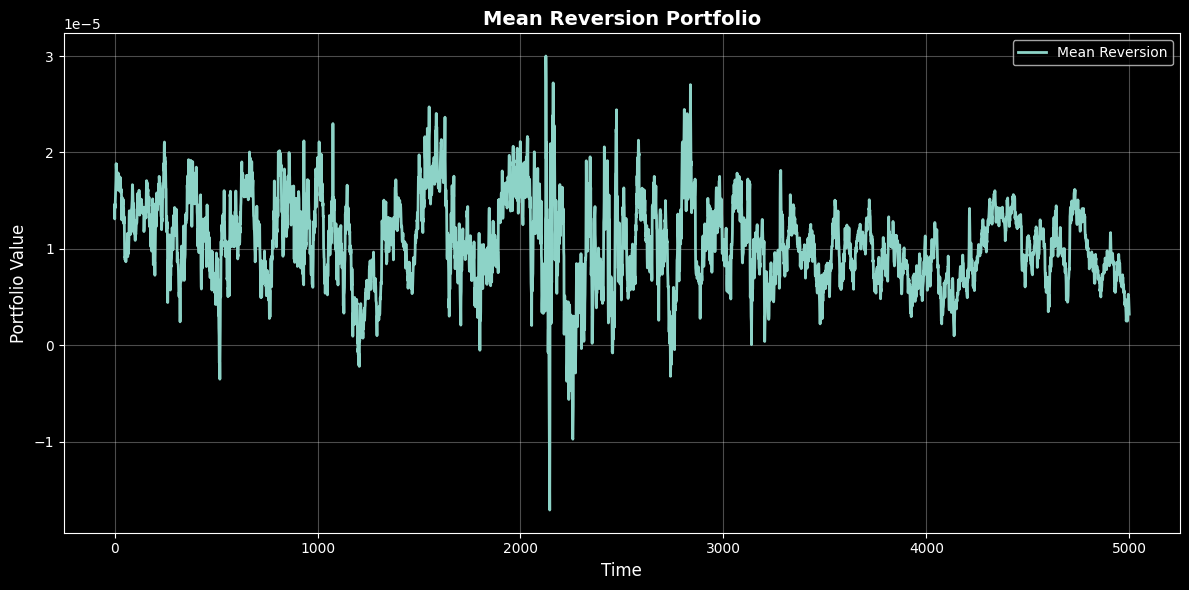

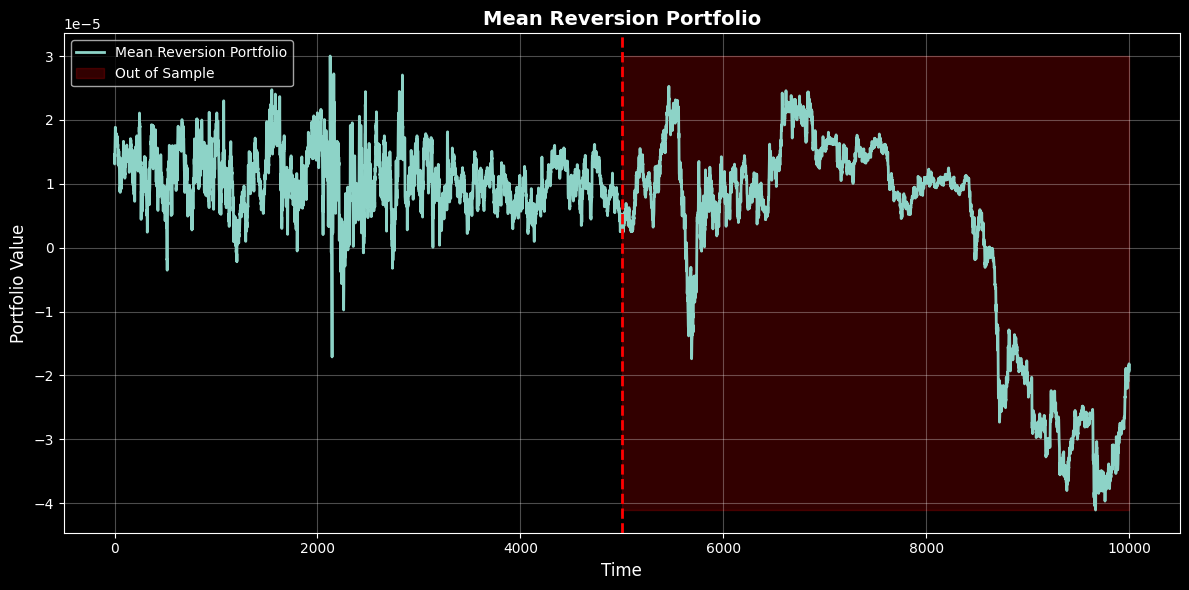

In [258]:
df_test = df.iloc[:5000, :] # Select first 5000 values to test
S = df_test.to_numpy()
A = np.linalg.inv(S[:-1, :].T @ S[:-1, :]) @ (S[:-1, :].T @ S[1:, :]) # Var(1) Linear Regression estimate
C = np.cov(S.T) # Convariance Matrix
C_sqrt = scipy.linalg.sqrtm(C)
C_sqrt_inv = np.linalg.inv(C_sqrt)
B = C_sqrt_inv @ A.T @ C @ A @ C_sqrt_inv
eig = np.linalg.eig(B)
eig_vals = eig[0]
eig_vectors = eig[1]
ind = np.argsort(eig_vals)
eig_vals = eig_vals[ind]
eig_vectors = eig_vectors[ind]

z_mr = eig_vectors[:, 0]
z_mom = eig_vectors[:, -1]

x_mr = np.array([C_sqrt_inv @ z_mr]).T
x_mom = np.array([C_sqrt_inv @ z_mom]).T

x_mr /= sum(abs(x_mr[:,0]))
x_mom /= sum(abs(x_mom[:,0]))
P_mr = (S @ x_mr)
P_mom = (S @ x_mom)

plt.figure(figsize=(12, 6))

# Plot Mean Reversion Portfolio
plt.plot(P_mr, label="Mean Reversion", linewidth=2)
plt.title("Mean Reversion Portfolio", fontsize=14, weight="bold")
plt.xlabel("Time", fontsize=12)
plt.ylabel("Portfolio Value", fontsize=12)
plt.grid(alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

P_mr_oos = df.iloc[:10000, :].to_numpy() @ x_mr
plt.figure(figsize=(12, 6))

# Plot Mean Reversion Portfolio
plt.plot(P_mr_oos, label="Mean Reversion Portfolio", linewidth=2)

# Add a red vertical line at x=5000
plt.axvline(x=5000, color="red", linestyle="--", linewidth=2)

# Shade everything to the right of x=5000
plt.fill_betweenx(
    y=[P_mr_oos.min(), P_mr_oos.max()],
    x1=5000,
    x2=len(P_mr_oos),
    color="red",
    alpha=0.2,
    label="Out of Sample"
)

# Plot customization
plt.title("Mean Reversion Portfolio", fontsize=14, weight="bold")
plt.xlabel("Time", fontsize=12)
plt.ylabel("Portfolio Value", fontsize=12)
plt.grid(alpha=0.3)
plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## Optimization/Parameter Estimation

In [209]:
def solve_sdp(A, B, k, first_prices=None, epsilon=1e-8):
    print("Starting Eigenvalue Optimization")
    A += epsilon * np.eye(A.shape[0])  # Regularize A
    B += epsilon * np.eye(B.shape[0])  # Regularize B
    
    n = A.shape[0]
    Y = cp.Variable((n, n), PSD=True)
    z = cp.Variable(nonneg=True)
    
    objective = cp.Minimize(cp.trace(A @ Y))
    constraints = [
        cp.trace(B @ Y) == 1,
        cp.trace(Y) - z == 0,
        cp.norm(Y, 1) - k * z <= 0,
    ]
    
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS)
    
    if problem.status not in ["optimal", "optimal_inaccurate"]:
        raise ValueError(f"Problem not solved to optimality. Status: {problem.status}")
    
    Y_opt = Y.value
    eig_vals, eig_vectors = np.linalg.eigh(Y_opt)
    x = eig_vectors[:, np.argmax(eig_vals)]
    if first_prices:
        x = (x / first_prices)
    x /= np.sum(np.abs(x))
    
    return x

In [210]:
def estimate_covariance_matrix(data):
    C = np.cov(data.T)
    # Ensure C is positive semidefinite
    eig_vals, eig_vectors = np.linalg.eigh(C)
    eig_vals = np.clip(eig_vals, a_min=0, a_max=None)
    C = eig_vectors @ np.diag(eig_vals) @ eig_vectors.T

    return C

def estimate_matrices(data):
    centered_data = data - data.mean()
    S = centered_data.to_numpy()

    # Estimate A (lag-1 variance) and C (covariance)
    A = np.linalg.inv(S[:-1].T @ S[:-1]) @ (S[:-1].T @ S[1:])
    C = estimate_covariance_matrix(data)

    return A, C

def calculate_mr_weights(data, k):
    A, C = estimate_matrices(data)
    A = A.T @ C @ A
    weights = solve_sdp(A, C, k)
    return weights

In [211]:
def estimate_var1_lasso(data, alpha=0.1):
    print("Estimating Var(1)-Matrix")
    n_assets = data.shape[1]
    A = np.zeros((n_assets, n_assets))
    
    # Regress each asset's return on lagged values
    for i in range(n_assets):
        y = data[1:, i]
        X = data[:-1]
        lasso = Lasso(alpha=alpha, fit_intercept=False, max_iter=100000)
        lasso.fit(X, y)
        A[:, i] = lasso.coef_

    return A

def estimate_covariance_glasso(data, alpha=0.1):
    print("Estimating Covariance")
    C = estimate_covariance_matrix(data)
    model = GraphicalLasso(alpha=alpha, covariance="precomputed", max_iter=100000, tol=1e-6, mode='cd')
    model.fit(C)
    C = model.covariance_

    return C

def calculate_mr_weights_lasso(data, k, alpha_A=0.1, alpha_cov=0.1):
    print("Estimating Matrices")
    data = data.to_numpy()
    A = estimate_var1_lasso(data, alpha=alpha_A)
    C = estimate_covariance_glasso(data, alpha=alpha_cov)
    A_transformed = A.T @ C @ A
    weights = solve_sdp(A_transformed, C, k)
    return weights

## Show Sample Portfolio

#### Optimization Parameters

In [212]:
start_time = 0
training_size = 1000
out_of_sample_size = 500
k = 12 # Sparsity constraint (lower -> less assets)
alpha_A = 0.1
alpha_cov = 0.01

Estimating Matrices
Estimating Var(1)-Matrix
Estimating Covariance


/Users/simonbachhuber/Documents/Quant/Research/SMRP/.venv/lib/python3.13/site-packages/sklearn/covariance/_graph_lasso.py:192: ConvergenceWarning: graphical_lasso: did not converge after 100000 iteration: dual gap: 4.230e-02
  warnings.warn(


Starting Eigenvalue Optimization


0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43
LTCUSDT,EGLDUSDT,ZECUSDT,DOTUSDT,SHIBUSDT,FLOWUSDT,ADAUSDT,LINKUSDT,VETUSDT,ATOMUSDT,BNBUSDT,TRXUSDT,ICPUSDT,DOGEUSDT,EOSUSDT,THETAUSDT,LRCUSDT,BTCUSDT,FILUSDT,AVAXUSDT,FTMUSDT,SOLUSDT,NEARUSDT,ETCUSDT,XTZUSDT,ENJUSDT,RUNEUSDT,AXSUSDT,SANDUSDT,XRPUSDT,CRVUSDT,ETHUSDT,BATUSDT,UNIUSDT,MANAUSDT,1INCHUSDT,BCHUSDT,HBARUSDT,ALGOUSDT,KSMUSDT,GRTUSDT,CHZUSDT,STXUSDT,XLMUSDT
0.022818,-0.071788,-0.020632,-0.006112,0.038955,0.051483,0.000069,0.033649,-0.035769,0.035371,0.006237,-0.022299,-0.019426,-0.03173,-0.00422,0.045527,-0.010939,0.029288,0.001276,0.01228,-0.002517,0.000987,-0.024367,-0.003881,-0.009636,0.022169,-0.086821,0.000129,0.050049,-0.000579,-0.013365,0.014177,0.002722,-0.022956,0.018364,-0.00209,0.019436,0.031757,0.076545,-0.025849,-0.004966,-0.009726,0.0438,-0.013243


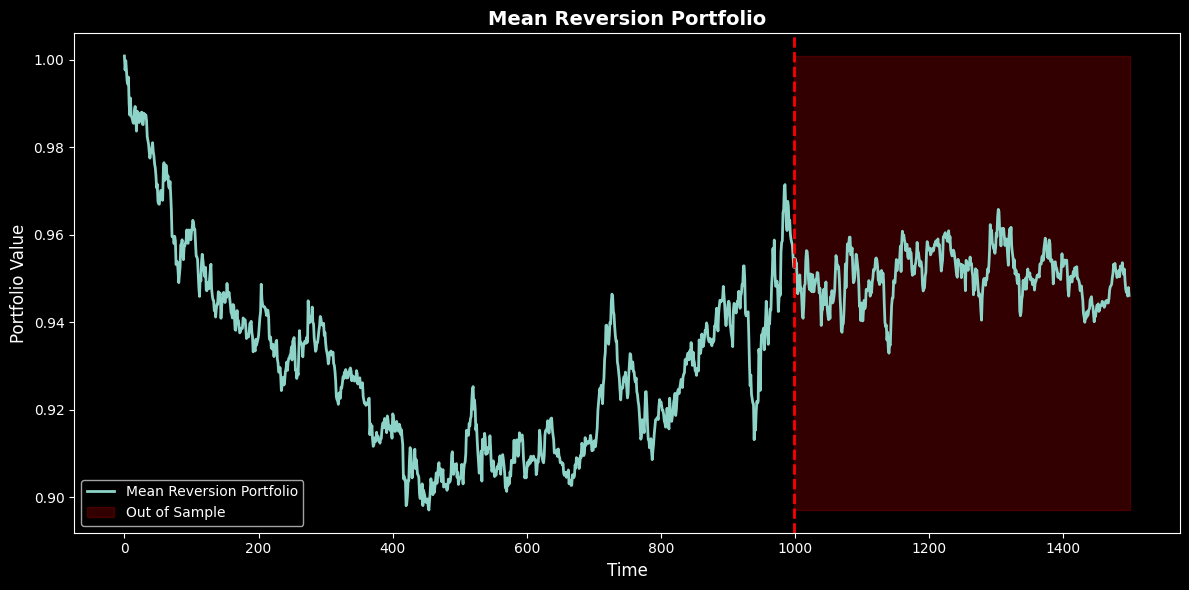

In [252]:
end_time = start_time + training_size
out_of_sample_end = end_time + out_of_sample_size

df_train = df.iloc[start_time:end_time]
df_test = df.iloc[start_time:out_of_sample_end, :]
first_prices = df_train.iloc[0, :]
df_standardized = df_train / first_prices
test_rets = df_test.pct_change().iloc[1:, :]

weights = calculate_mr_weights_lasso(df_standardized, k, alpha_A, alpha_cov)
display(HTML(pd.DataFrame({"Index": df.columns, "Values": weights}).T.to_html(index=False, justify='center')))
portfolio_returns = test_rets @ weights
portfolio_cumreturns = np.cumprod(1 + portfolio_returns)
plt.figure(figsize=(12, 6))

# Plot Mean Reversion Portfolio
plt.plot(portfolio_cumreturns.values, label="Mean Reversion Portfolio", linewidth=2)

plt.axvline(x=len(portfolio_cumreturns) - out_of_sample_size, color="red", linestyle="--", linewidth=2)
plt.fill_betweenx(
    y=[portfolio_cumreturns.min(), portfolio_cumreturns.max()],
    x1=len(portfolio_cumreturns) - out_of_sample_size,
    x2=len(portfolio_cumreturns),
    color="red",
    alpha=0.2,
    label="Out of Sample"
)

plt.title("Mean Reversion Portfolio", fontsize=14, weight="bold")
plt.xlabel("Time", fontsize=12)
plt.ylabel("Portfolio Value", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

## Backtest

#### Trading Strategy Parameters

In [253]:
window = 100
entry_th = 1.0

Sharpe Ratio: 7.581001504684443


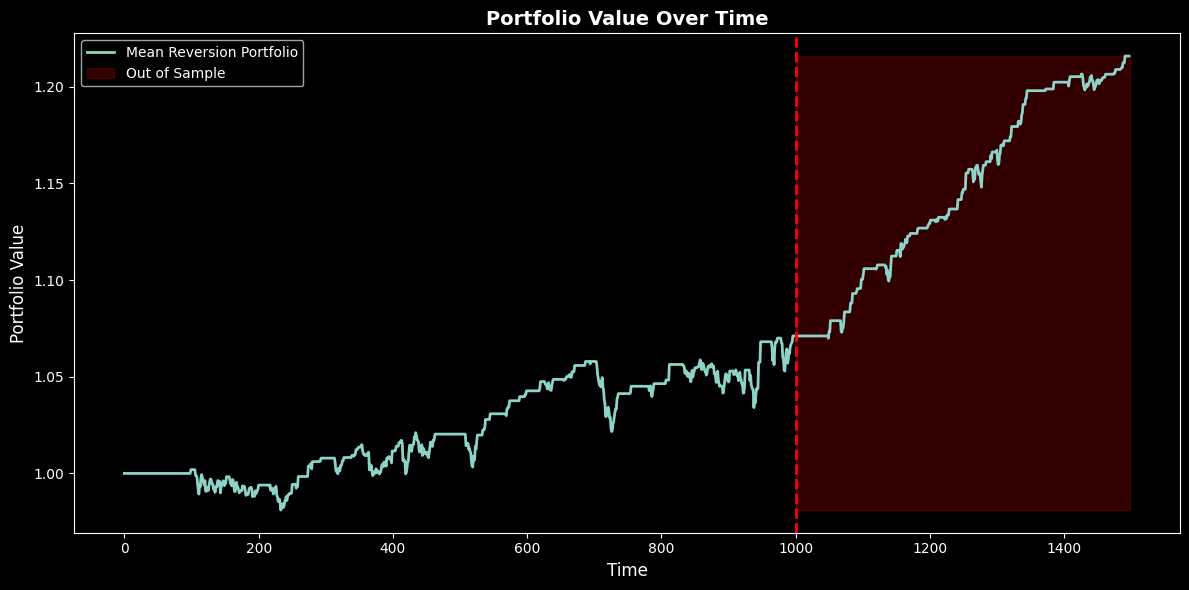

In [254]:
mean_p = portfolio_cumreturns.rolling(window=window).mean()
std_p = portfolio_cumreturns.rolling(window=window).std()
upper_threshold = mean_p + entry_th * std_p
lower_threshold = mean_p - entry_th * std_p

position = np.zeros_like(portfolio_cumreturns)
position[portfolio_cumreturns < lower_threshold] = 1
position[portfolio_cumreturns > upper_threshold] = -1

strategy_returns = position[:-1] * portfolio_returns[1:]
strategy_cumreturns = np.cumprod(1+strategy_returns).values

sharpe_ratio = (strategy_returns.mean() / strategy_returns.std()) * np.sqrt(365 * 24) # Annualize Sharpe Ratio
print("Sharpe Ratio:", sharpe_ratio)
plt.figure(figsize=(12, 6))

# Plot Mean Reversion Portfolio
plt.plot(strategy_cumreturns, label="Mean Reversion Portfolio", linewidth=2)

# Add a red vertical line at x=5000
plt.axvline(x=end_time, color="red", linestyle="--", linewidth=2)

# Shade everything to the right of x=5000
plt.fill_betweenx(
    y=[strategy_cumreturns.min(), strategy_cumreturns.max()],
    x1=end_time,
    x2=len(strategy_cumreturns),
    color="red",
    alpha=0.2,
    label="Out of Sample"
)

plt.title("Portfolio Value Over Time", fontsize=14, weight="bold")
plt.xlabel("Time", fontsize=12)
plt.ylabel("Portfolio Value", fontsize=12)
plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## Simulate Price Movements

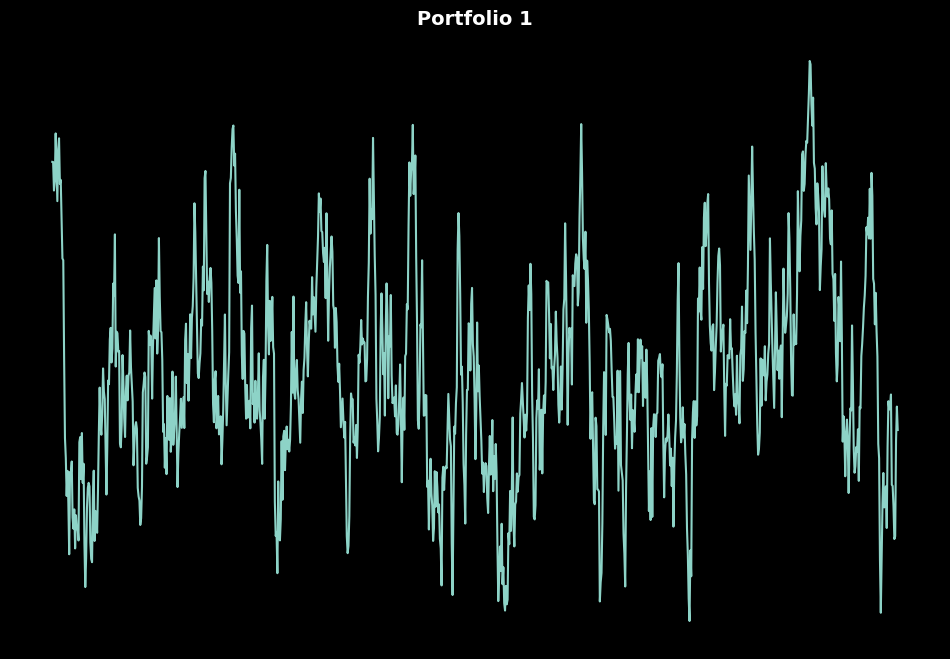

In [255]:
np.random.seed(42)

# Parameters for Ornstein-Uhlenbeck process
T = 1000       # number of time steps
dt = 1.0       # time increment
lambda_ = 0.1  # speed of mean reversion
mu = 0.0        # long-term mean
sigma = 0.2     # volatility

# Initialize the time series
X = np.zeros(T)
X[0] = 1.0  # starting value

# Simulate the OU process
for t in range(1, T):
    dW = np.random.normal(0, np.sqrt(dt))
    X[t] = X[t-1] + lambda_*(mu - X[t-1])*dt + sigma*dW

# Plot the simulated mean-reverting portfolio
plt.figure(figsize=(12,8))
plt.title("Portfolio 1", fontsize=14, weight="bold")
plt.plot(X)
plt.axis('off')
plt.show()

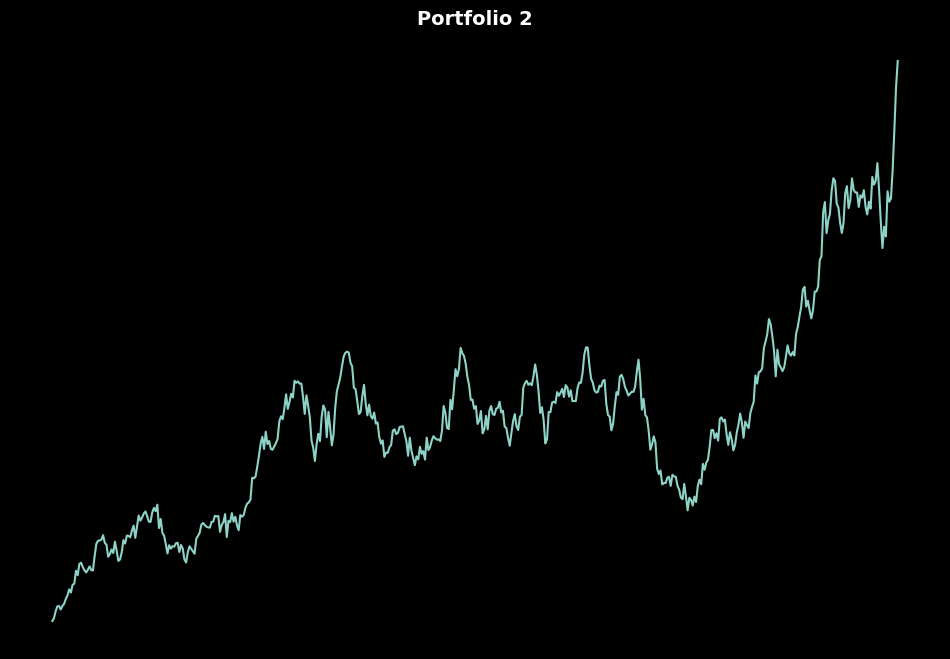

In [256]:
# Parameters for Geometric Brownian Motion
T = 500      # number of time steps (e.g., one trading year of daily data)
dt = 1.0/252  # one day in years if we assume 252 trading days
mu = 0.05      # annual expected return (e.g. 5%)
sigma = 0.5    # annual volatility (e.g. 20%)
S0 = 100.0     # initial stock price

# Initialize the price array
S = np.zeros(T)
S[0] = S0

# Simulate the GBM
for t in range(1, T):
    # draw a random sample from normal distribution
    epsilon = np.random.normal(0, 1)
    # compute the return factor
    S[t] = S[t-1] * np.exp((mu - 0.5 * sigma**2)*dt + sigma * np.sqrt(dt)*epsilon)

# Plot the simulated stock price
plt.figure(figsize=(12,8))
plt.plot(S, label='Simulated Stock Price')
plt.title("Portfolio 2", fontsize=14, weight="bold")
plt.axis('off')
plt.show()